Processing round2 files in R2: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


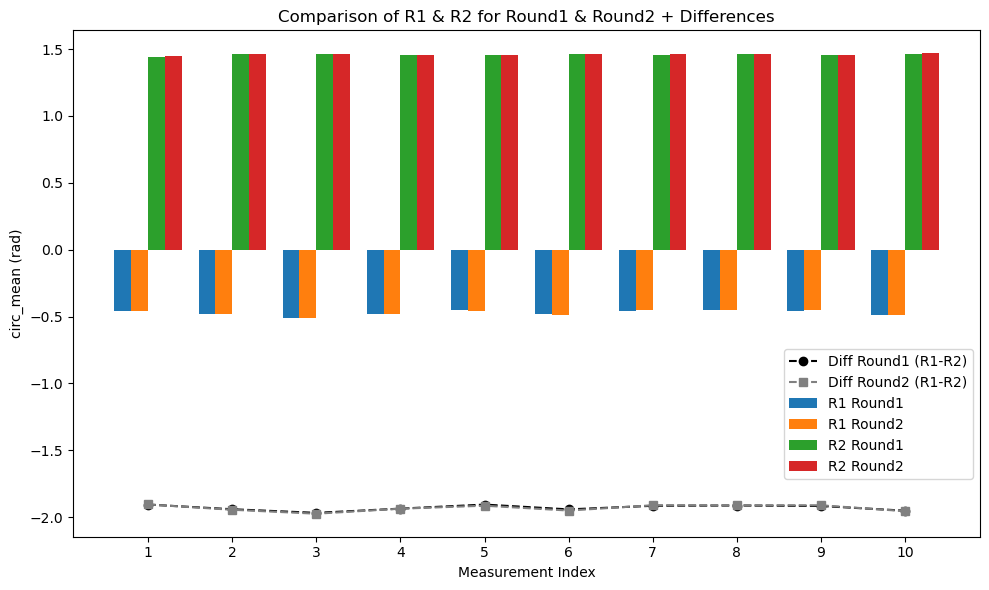

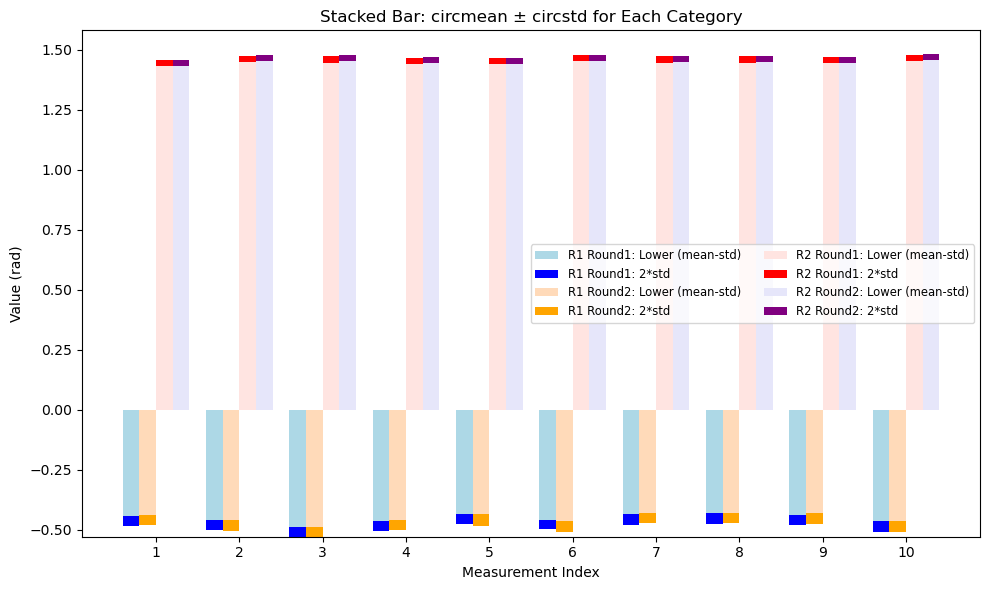

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import tools
from tqdm import tqdm
%matplotlib inline
def parse_timestamp(filename, round_tag):
    """
    从文件名中提取时间戳。
    假设文件名格式类似：data_offline_pilot_round1_20250311_141048.npy
    round_tag 为 "round1" 或 "round2"。
    返回形如 "20250311_141048" 的字符串；若无法解析则返回 None。
    """
    if round_tag not in filename:
        return None
    parts = filename.split(round_tag + "_")
    if len(parts) < 2:
        return None
    timestamp_str = parts[1].replace(".npy", "")
    if not timestamp_str:
        return None
    return timestamp_str

def compute_circ_stats(iq_samples):
    """
    给定二维 IQ 数据 (2, N)，计算相位差的 circmean 与 circstd，并返回二者值。
    此处均采用弧度单位（deg=False），确保工具函数的一致性。
    """
    phase_ch0, _ = tools.get_phases_and_apply_bandpass(iq_samples[0, :])
    phase_ch1, _ = tools.get_phases_and_apply_bandpass(iq_samples[1, :])
    phase_diff = tools.to_min_pi_plus_pi(phase_ch0 - phase_ch1, deg=False)
    circ_mean_val = tools.circmean(phase_diff, deg=False)
    circ_std_val = tools.circstd(phase_diff, deg=False)
    return circ_mean_val, circ_std_val

def get_sorted_stats(folder_path, round_tag):
    """
    遍历 folder_path 中所有包含 round_tag 的 .npy 文件，
    计算每个文件的 circmean 与 circstd，并解析出时间戳。
    返回按时间戳升序排序的列表：[(timestamp, circmean, circstd), ...]
    """
    results = []
    files = os.listdir(folder_path)
    for filename in tqdm(files, desc=f"Processing {round_tag} files in {os.path.basename(folder_path)}"):
        if filename.endswith(".npy") and round_tag in filename:
            full_path = os.path.join(folder_path, filename)
            timestamp_str = parse_timestamp(filename, round_tag)
            if not timestamp_str:
                continue
            try:
                iq_samples = np.load(full_path)
                circ_mean_val, circ_std_val = compute_circ_stats(iq_samples)
                results.append((timestamp_str, circ_mean_val, circ_std_val))
            except Exception as e:
                print(f"处理文件 {filename} 出错: {e}")
    results.sort(key=lambda x: x[0])
    return results

def main():
    # -----------------------------
    # 第一部分：原有柱状图 + 折线图
    # -----------------------------
    current_dir = os.getcwd()
    r1_dir = os.path.join(current_dir, "R1")
    r2_dir = os.path.join(current_dir, "R2")

    # 分别获取 R1 和 R2 中 round1 与 round2 的统计数据
    r1_round1_stats = get_sorted_stats(r1_dir, "round1")  # 每个元素: (timestamp, circmean, circstd)
    r1_round2_stats = get_sorted_stats(r1_dir, "round2")
    r2_round1_stats = get_sorted_stats(r2_dir, "round1")
    r2_round2_stats = get_sorted_stats(r2_dir, "round2")

    # 假设各列表按测量顺序对应，取最短长度
    min_len = min(len(r1_round1_stats), len(r1_round2_stats),
                  len(r2_round1_stats), len(r2_round2_stats))
    if min_len == 0:
        print("无法绘制：至少一组 round1/round2 数据为空或无法匹配。")
        return

    # 提取各类别的 circmean 值（原图只用 circmean，不显示 std）
    r1_round1_vals = [r1_round1_stats[i][1] for i in range(min_len)]
    r1_round2_vals = [r1_round2_stats[i][1] for i in range(min_len)]
    r2_round1_vals = [r2_round1_stats[i][1] for i in range(min_len)]
    r2_round2_vals = [r2_round2_stats[i][1] for i in range(min_len)]

    # 横坐标序列：测量序号，从 1 开始
    x = np.arange(1, min_len + 1)
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - 3*width/2, r1_round1_vals, width, label='R1 Round1')
    ax.bar(x -   width/2, r1_round2_vals, width, label='R1 Round2')
    ax.bar(x +   width/2, r2_round1_vals, width, label='R2 Round1')
    ax.bar(x + 3*width/2, r2_round2_vals, width, label='R2 Round2')

    # 分别计算 Round1 和 Round2 中 R1 与 R2 的差值
    diff_round1 = [r1_round1_vals[i] - r2_round1_vals[i] for i in range(min_len)]
    diff_round2 = [r1_round2_vals[i] - r2_round2_vals[i] for i in range(min_len)]
    ax.plot(x, diff_round1, marker='o', color='black', linestyle='--', label='Diff Round1 (R1-R2)')
    ax.plot(x, diff_round2, marker='s', color='gray', linestyle='--', label='Diff Round2 (R1-R2)')

    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in x])
    ax.set_xlabel('Measurement Index')
    ax.set_ylabel('circ_mean (rad)')
    ax.set_title('Comparison of R1 & R2 for Round1 & Round2 + Differences')
    ax.legend(loc='lower right', bbox_to_anchor=(1, 0.1))
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 第二部分：新绘制的堆叠图
    # 展示每个类别的 circmean ± circstd（堆叠图形式）
    # -----------------------------
    # 分别提取各类别的 circmean 和 circstd
    r1_r1_means = [r1_round1_stats[i][1] for i in range(min_len)]
    r1_r1_stds  = [r1_round1_stats[i][2] for i in range(min_len)]
    r1_r2_means = [r1_round2_stats[i][1] for i in range(min_len)]
    r1_r2_stds  = [r1_round2_stats[i][2] for i in range(min_len)]
    r2_r1_means = [r2_round1_stats[i][1] for i in range(min_len)]
    r2_r1_stds  = [r2_round1_stats[i][2] for i in range(min_len)]
    r2_r2_means = [r2_round2_stats[i][1] for i in range(min_len)]
    r2_r2_stds  = [r2_round2_stats[i][2] for i in range(min_len)]

    # 计算下界 = circmean - circstd 和堆叠部分高度 = 2 * circstd
    lower_r1r1 = [m - s for m, s in zip(r1_r1_means, r1_r1_stds)]
    range_r1r1 = [2 * s for s in r1_r1_stds]

    lower_r1r2 = [m - s for m, s in zip(r1_r2_means, r1_r2_stds)]
    range_r1r2 = [2 * s for s in r1_r2_stds]

    lower_r2r1 = [m - s for m, s in zip(r2_r1_means, r2_r1_stds)]
    range_r2r1 = [2 * s for s in r2_r1_stds]

    lower_r2r2 = [m - s for m, s in zip(r2_r2_means, r2_r2_stds)]
    range_r2r2 = [2 * s for s in r2_r2_stds]

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    # 绘制堆叠柱状图：每个测量点各类别分别画出下界和堆叠部分
    p1 = ax2.bar(x - 3*width/2, lower_r1r1, width, color='lightblue', label='R1 Round1: Lower (mean-std)')
    p2 = ax2.bar(x - 3*width/2, range_r1r1, width, bottom=lower_r1r1, color='blue', label='R1 Round1: 2*std')

    p3 = ax2.bar(x - width/2, lower_r1r2, width, color='peachpuff', label='R1 Round2: Lower (mean-std)')
    p4 = ax2.bar(x - width/2, range_r1r2, width, bottom=lower_r1r2, color='orange', label='R1 Round2: 2*std')

    p5 = ax2.bar(x + width/2, lower_r2r1, width, color='mistyrose', label='R2 Round1: Lower (mean-std)')
    p6 = ax2.bar(x + width/2, range_r2r1, width, bottom=lower_r2r1, color='red', label='R2 Round1: 2*std')

    p7 = ax2.bar(x + 3*width/2, lower_r2r2, width, color='lavender', label='R2 Round2: Lower (mean-std)')
    p8 = ax2.bar(x + 3*width/2, range_r2r2, width, bottom=lower_r2r2, color='purple', label='R2 Round2: 2*std')

    ax2.set_xticks(x)
    ax2.set_xticklabels([str(i) for i in x])
    ax2.set_xlabel('Measurement Index')
    ax2.set_ylabel('Value (rad)')
    ax2.set_title('Stacked Bar: circmean ± circstd for Each Category')
    ax2.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
